<a href="https://colab.research.google.com/github/tawfiqam/MI564/blob/main/LDA_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install psaw

In [ ]:
import pandas as pd
#we will need datetime in order to specify the timeline we need to collect the data
import datetime as dt
#regular expressions will help us clean the text
import re
#gensim
import gensim
#LDA model
from gensim.models import LdaModel
#Use this to setup a dictionay
from gensim.corpora import Dictionary
#This will allow us to get the coherence models
from gensim.models import CoherenceModel
#gensim is a python library used mostly for NLP analysis
#corpora allows us to build a corpus out of different 
#documents
from gensim import corpora
#Defaultdict is a container like dictionaries present in the module collections. 
#Defaultdict is a sub-class of the dict class that returns a dictionary-like object. 
#The functionality of both dictionaries and defualtdict are almost same except for 
#the fact that defualtdict never raises a KeyError. It provides a default value 
#for the key that does not exists.
from collections import defaultdict

#importing ntlk
#we will be using nltk to create bag of words
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
#use nltk to get stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#create a stoplist that includes all the english stop words
stopwords_english = stopwords.words('english')
display('here is a subset of the stop words')
display(stopwords_english[0:10])
#now we import the wrapper in order to use the API
# Text Cleaning
import string

from psaw import PushshiftAPI

api = PushshiftAPI()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'here is a subset of the stop words'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item. For example, if we are looking through a document and want to do topic modeling, it is important that we do not see each inflection of the word differently. That would confuse the topic modeling algorithm. So, for example, we'd want to see the words "studies" "studied" and "studying" as "study." [1,2]




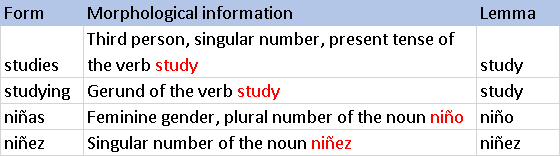

Another simpler way of doing this is called stemming. Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always, and that is why we affirm that this approach presents some limitations.

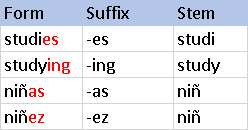

References:

[1] https://en.wikipedia.org/wiki/Lemmatisation

[2] [https://blog.bitext.com what-is-the-difference-between-stemming-and-lemmatization/]()

In [ ]:
#We are using nltk lemmatizer 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
#this function will allow us to find the last day of each month
#for example, there are 31 days in January, but 28 this February
def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [ ]:
import datetime
subredditlist = ['Ex_Foster']
for reddit in subredditlist:
    for y in range(2019,2021):
      for i in range(1,12):
          file_name= str(reddit)+"_"+str(y)+"_"+str(i)+".json"
          print("starting with the month "+str(i))
          print("for subreddit..."+str(reddit))
          print("setting start epoch...")
          start_epoch=int(dt.datetime(y, i, 1).timestamp())
          print("setting end epoch...")
          last_day = last_day_of_month(datetime.date(y, i, 1))
          print("the last day of the month is...")
          print(last_day.day)
          last_day = int(last_day.day)
          end_epoch = int(dt.datetime(y,i,last_day).timestamp())
          print("setting up the generator...")
          gen = api.search_comments(after=start_epoch, before=end_epoch,subreddit=reddit)
          print("setting up the dataframe...")
          df = pd.DataFrame([obj.d_ for obj in gen])
          print("The number of comments for year "+ str(y)+" and month "+str(i)+" is "+str(len(df.index)))
          df.to_json(file_name)

starting with the month 1
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 1 is 0
starting with the month 2
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
28
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 2 is 0
starting with the month 3
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 3 is 69
starting with the month 4
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
30
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 4 is 233
starting with the month 5
for sub

/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


The number of comments for year 2019 and month 6 is 183
starting with the month 7
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 7 is 78
starting with the month 8
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 8 is 80
starting with the month 9
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
30
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 9 is 229
starting with the month 10
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for ye

In [ ]:
#creating smaller dataframe
df = df[['id','link_id','body','created','author']]

In [ ]:
def first_pass(text): 
    text = str(text)
    #remove newline character code
    text = text.replace('\\n',' ')
    #remove the ampersand character code
    text = text.replace('&amp',' ')
    #character code for a Zero-witdh space, which is a character that acts like a spacebar, except it's invisible
    #https://www.reddit.com/r/OutOfTheLoop/comments/9abjhm/what_does_x200b_mean/
    text = text.replace(';#x200B;',' ')
    #A commonly used character in HTML is the non-breaking space: &nbsp;
    text = text.replace('nbsp',' ')
    
    return text

In [86]:
#We will consider all the comments in each of the reddit threads a document
#link_id is used to identify each thread
df_p = df.reset_index().groupby("link_id",as_index=False )['body'].apply(lambda x: ','.join(x))

p_threads = df_p.values

df_p_threads = pd.DataFrame(p_threads)
df_p_threads.rename(columns={0: "comment_thread", 1: "body"},inplace=True)

In [87]:
df_p_threads['body']

0     It's good to know that there are people out th...
1     I have been out of the system for over 20 year...
2     I was in foster care for about a year and a ha...
3     I  have to remember kids in care have been aba...
4     Good for you Mushroom! I'm sorry it's been a s...
5     I relate to this a lot. It's a weird place to ...
6     Oh thank god, I was worrying about that.,Depen...
7     One of my favorite things is volunteering beca...
8     I opened the form again to check, but I don't ...
9     This is amazing. Sending you love and support....
10    I usually say I don’t celebrate or I’m going o...
11    You don't need to put your username! This isn'...
12    Can you tell me your state (or PM me)?,Thank y...
13    I am the same age and too have a family with c...
14    I don't have opiate/benzo drug use as a negati...
15    Posting specifically because you said you are ...
Name: body, dtype: object

In [88]:
df_p_threads['clean_text'] = df_p_threads.body.apply(first_pass)

In [ ]:
def second_pass(text): 
    #make string lowercase 
    text = str(text)
    text = text.lower()
    
    #remove links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

    #tokenize
    #create bag of words
    #1-grams 
    tokens = nltk.word_tokenize(text) 
    clean_text = []
    
    #remove stopwords, puncuation, then lemmatize
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation): 
            token = wordnet_lemmatizer.lemmatize(word)
            clean_text.append(token)
            
    #remove words of length 3 or smaller        
    clean_text = [token for token in clean_text if len(token) > 3] 
            
    return clean_text      

In [89]:
df_p_threads['clean_text'] = df_p_threads.body.apply(second_pass)

In [90]:
df_p_threads.clean_text

0     [good, know, people, trying, right, thing, tho...
1     [system, year, every, really, dream, sadly, pa...
2     [foster, care, year, half, adopted, different,...
3     [remember, care, abandoned, adult, supposed, p...
4     [good, mushroom, sorry, shit, fest, teacher, g...
5     [relate, weird, place, realize, parent, like, ...
6     [thank, worrying, that., depends, federal, bac...
7     [favorite, thing, volunteering, brings, closer...
8     [opened, form, check, question, like, sorry, m...
9     [amazing, sending, love, support., good, ex\_f...
10    [usually, celebrate, going, trip, stop, questi...
11    [need, username, reddit, thing, also, posting,...
12    [tell, state, thank, explaining, much, appreci...
13    [family, child, shall, think, overcome, always...
14    [opiate/benzo, drug, negative, mark, anymore, ...
15    [posting, specifically, said, coping, well, we...
Name: clean_text, dtype: object

In [93]:
docs = df_p_threads.clean_text

In [94]:
docs

0     [good, know, people, trying, right, thing, tho...
1     [system, year, every, really, dream, sadly, pa...
2     [foster, care, year, half, adopted, different,...
3     [remember, care, abandoned, adult, supposed, p...
4     [good, mushroom, sorry, shit, fest, teacher, g...
5     [relate, weird, place, realize, parent, like, ...
6     [thank, worrying, that., depends, federal, bac...
7     [favorite, thing, volunteering, brings, closer...
8     [opened, form, check, question, like, sorry, m...
9     [amazing, sending, love, support., good, ex\_f...
10    [usually, celebrate, going, trip, stop, questi...
11    [need, username, reddit, thing, also, posting,...
12    [tell, state, thank, explaining, much, appreci...
13    [family, child, shall, think, overcome, always...
14    [opiate/benzo, drug, negative, mark, anymore, ...
15    [posting, specifically, said, coping, well, we...
Name: clean_text, dtype: object

In [95]:
# Get token frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in docs:
    for token in text:
        frequency[token]+=1


In [96]:
wordfreq = {}
for text in docs:
    for token in text:
        wordfreq[token]=frequency[token]

In [97]:
from itertools import islice

import operator

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

higherfreq2 = {k:v for k, v in wordfreq.items() if v>10}  
sorted_x = sorted(higherfreq2.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_x)

[('like', 42), ('family', 39), ('people', 29), ('know', 26), ('going', 25), ('year', 23), ('even', 22), ('thing', 21), ('foster', 21), ('feel', 21), ('life', 21), ('want', 21), ('sorry', 21), ('care', 20), ('good', 19), ('time', 19), ('home', 17), ('really', 17), ('help', 16), ('parent', 15), ('love', 15), ('could', 14), ('would', 13), ('always', 13), ('better', 13), ('also', 12), ('though', 12), ('need', 12), ('someone', 12), ('much', 11), ('well', 11), ('come', 11), ('take', 11), ('make', 11), ('work', 11), ('holiday', 11)]


In [98]:
dictionary = corpora.Dictionary(docs)
print(len(dictionary))
dictionary.save('Ex_Foster.dict')
print(dictionary)

1081
Dictionary(1081 unique tokens: ['agree', 'also', 'appreciate', 'asian', 'attempt']...)


In [99]:
corpus = [dictionary.doc2bow(text) for text in docs]
corpora.MmCorpus.serialize('Ex_Foster.mm', corpus)
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 3), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 5), (50, 1), (51, 2), (52, 2), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 5), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 3), (94, 1), (95, 2), (96, 2), (97, 1), (98, 1), (99, 2), (100, 2), (101, 1), (102, 1), (103, 2), (104, 1), (105, 2), (106, 2)]]


In [100]:
id2word = corpora.Dictionary(docs)

In [101]:
print(id2word[0])

agree


In [102]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('agree', 1), ('also', 1), ('appreciate', 1), ('asian', 1), ('attempt', 1), ('become', 1), ('beside', 1), ('brother', 1), ('business', 1), ('calling', 1), ('care', 1), ('certainly', 1), ('closeness', 1), ('compared', 1), ('considered', 1), ('constantly', 1), ('could', 1), ('cousin', 1), ('degrading', 1), ('descriptive', 1), ('discussion', 1), ('encouraging', 1), ('even', 2), ('family', 1), ('farm', 1), ('fault', 1), ('feel', 1), ('feeling', 1), ('foster', 2), ('fostering', 1), ('found', 1), ('friend', 1), ('front', 2), ('going', 1), ('good', 3), ('great', 1), ('happy', 2), ('harder', 1), ('healthy', 1), ('hear', 1), ('heart', 1), ('help', 1), ('home', 2), ('horse', 2), ('ignorant', 1), ('ingrain', 1), ('insensitive', 1), ('keeping', 1), ('kitten', 1), ('know', 5), ('lead', 1), ('letting', 2), ('life', 2), ('like', 2), ('little', 1), ('lkid', 1), ('longest', 1), ('meaning', 1), ('much', 1), ('nephew', 2), ('never', 1), ('normalizing', 1), ('nothing', 2), ('opinion', 1), ('others', 1),

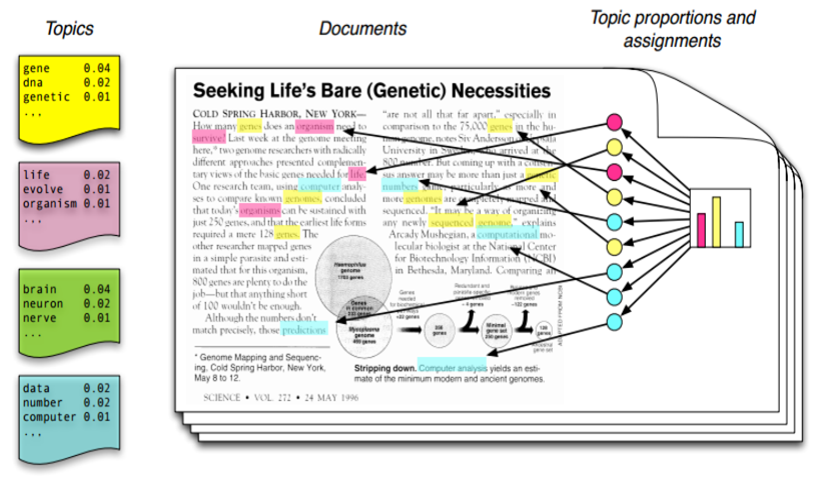

In [103]:
def compute_coherence_values(dictionary, corpus, texts, limit=100, start=10, step=10):
    """
    You will need to change the chunksize in reference to the size of the corpus. A more detailed explanation can be found here:
    https://miningthedetails.com/blog/python/lda/GensimLDA/
    
    For the Parenting and MensRightrs corpora, I think the chunksize would be around 50,000
    
    Compute c_v coherence for various number of topics
    
    Parameters to change:
    -----------
    chunksize
    workers:
    on big laptop, the total number of cores = 8, so set to 6 (usually n-2)
    on small laptop, the local numeber of cores = 5, so set to 3
    on server, set to 9-10 workers

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts (docs or documents)
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    chunksize = 1000
    passes = 20
    workers = 6
    
    coherence_values = []
    model_list = []
    #setup the LDA model 
    #it is multicore so we can run multiple models together
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics, 
                                   random_state=100,
                                   chunksize=chunksize,
                                   passes=passes,
                                   per_word_topics=True,
                                   workers=workers)
        print('saving the LDA model...')
        Filename = "LDA_Model_"+str(num_topics)+".model"
        model.save(Filename)
        model_list.append(model)
        print('done with model ',str(num_topics))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print('coherence metric is ',str(coherencemodel.get_coherence()))
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


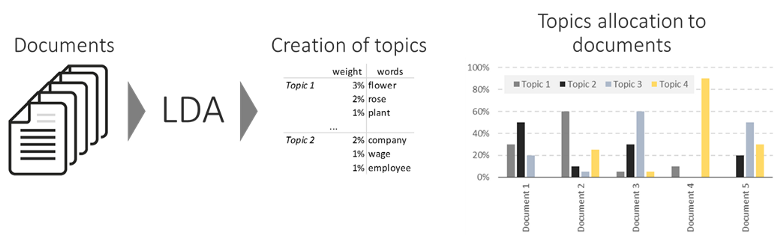

In [105]:
# Can take a long time to run.
#start from 10 topics
#with a step of 1 topic
#continue adding more topics until we get to 30 topics
limit = 31
start = 10
step  = 1

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)


saving the LDA model...
done with model  10
coherence metric is  0.3225025680611331
saving the LDA model...
done with model  11
coherence metric is  0.34498331078315536
saving the LDA model...
done with model  12
coherence metric is  0.34569831737303436
saving the LDA model...
done with model  13
coherence metric is  0.27100030372872985
saving the LDA model...
done with model  14
coherence metric is  0.3105078259609055
saving the LDA model...
done with model  15
coherence metric is  0.3283635189989647
saving the LDA model...
done with model  16
coherence metric is  0.32063268712625004
saving the LDA model...
done with model  17
coherence metric is  0.3408811043327509
saving the LDA model...
done with model  18
coherence metric is  0.33935484461557663
saving the LDA model...
done with model  19
coherence metric is  0.3521506246837386
saving the LDA model...
done with model  20
coherence metric is  0.3709714835901686
saving the LDA model...
done with model  21
coherence metric is  0.3370

In [106]:
#these are the packages we use when plotting figures using Pandas DataFrames in a notebook. 
#check the introduction to Pandas for details (https://github.com/tawfiqam/MI564/blob/main/Pandas_Introduction.ipynb)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20,'figure.figsize':(10,8)})

Remember back when we were looking for the best number (K) for Kmeans clustering. We used the Elbow Method...see below as a reminder

In [ ]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    #inertia_float:Sum of squared distances of samples to their closest cluster center
    #remember the explanation of K-means as the average between the points
    #the lower the error, the better
    Error.append(kmeans.inertia_)

plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

NameError: ignored

We are going to do something similar with the coherence scores for each of the models we created to find the best number of LDA topics (k). 

In order to find the optimum number of topics for the LDA model, we trained 9 LDA models starting with a number of topics k=10, with a step of 10 topics until a limit of 200 topics. 

For each of these k iterations, we calculated the coherence of the LDA models using the gensimCoherenceModelfeature5. This feature measures the coherence score of the topics in the LDA model.

Coherence values have been found to be better at approximating human rating of LDA model“understandability” [3] than other measures like perplexity [4]. 

The figure below shows the coherence values for each of the LDA models. We used these scores as a guide to analyze a subset of the LDAmodels. 

References:

[3] Michael Röder, Andreas Both, and Alexander Hinneburg. 2015. Exploring the Space of Topic Coherence Measures. InProceedings of the Eighth ACM International Conference on Web Search and Data Mining (WSDM ’15). ACM, New York,NY, USA, 399–408.   https://doi.org/10.1145/2684822.2685324 event-place: Shanghai, China

[4] Jonathan Chang, Sean Gerrish, Chong Wang, Jordan L. Boyd-Graber, and David M. Blei. 2009. Reading tea leaves:How humans interpret topic models. InAdvances in neural information processing systems. 288–296

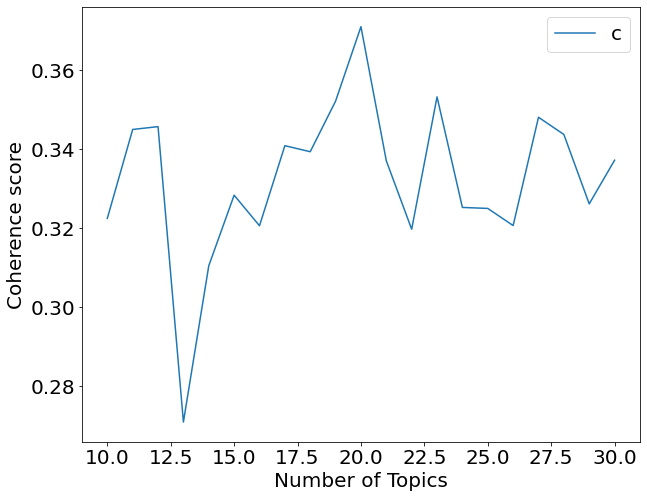

In [107]:
# Show graph
# As with the 
fig = plt.gcf()

limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDA_models_coherence.jpg')

In [108]:
# Print the coherence scores
coherence = zip(x, coherence_values)
sorted_coherence = sorted(coherence, key=lambda x: x[1], reverse=True)

print(sorted_coherence)

for m, cv in sorted_coherence:
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

[(20, 0.3709714835901686), (23, 0.35321836539028867), (19, 0.3521506246837386), (27, 0.34806904324115695), (12, 0.34569831737303436), (11, 0.34498331078315536), (28, 0.34371426925590515), (17, 0.3408811043327509), (18, 0.33935484461557663), (30, 0.3372060441622839), (21, 0.3370560540284292), (15, 0.3283635189989647), (29, 0.32616970011573854), (24, 0.32526623576627345), (25, 0.32501749901901333), (10, 0.3225025680611331), (26, 0.3206819819946661), (16, 0.32063268712625004), (22, 0.319756944065219), (14, 0.3105078259609055), (13, 0.27100030372872985)]
Num Topics = 20  has Coherence Value of 0.371
Num Topics = 23  has Coherence Value of 0.3532
Num Topics = 19  has Coherence Value of 0.3522
Num Topics = 27  has Coherence Value of 0.3481
Num Topics = 12  has Coherence Value of 0.3457
Num Topics = 11  has Coherence Value of 0.345
Num Topics = 28  has Coherence Value of 0.3437
Num Topics = 17  has Coherence Value of 0.3409
Num Topics = 18  has Coherence Value of 0.3394
Num Topics = 30  has C

In [110]:
#pretty print is used to show models in a claen way
import pprint
# Select the model and print the topics
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=True)
topics= optimal_model.print_topics(num_words=20)
topics

[(0,
  '0.032*"sorry" + 0.028*"loss" + 0.014*"really" + 0.014*"definitely" + 0.014*"tell" + 0.014*"love" + 0.014*"loved" + 0.014*"lose" + 0.009*"like" + 0.009*"sure" + 0.009*"hard" + 0.009*"someone" + 0.009*"easy" + 0.009*"care" + 0.009*"well" + 0.009*"please" + 0.009*"life" + 0.009*"stopped" + 0.009*"hurt" + 0.009*"take"'),
 (1,
  '0.026*"credit" + 0.021*"score" + 0.015*"work" + 0.015*"thing" + 0.015*"apartment" + 0.010*"really" + 0.010*"every" + 0.010*"someone" + 0.010*"could" + 0.010*"level" + 0.010*"good" + 0.010*"best" + 0.010*"federal" + 0.010*"answer" + 0.010*"thank" + 0.010*"know" + 0.010*"check" + 0.010*"insurance" + 0.010*"identity" + 0.010*"background"'),
 (2,
  '0.025*"people" + 0.017*"like" + 0.015*"help" + 0.012*"therapist" + 0.010*"know" + 0.010*"life" + 0.010*"therapy" + 0.010*"said" + 0.010*"drug" + 0.010*"love" + 0.008*"good" + 0.008*"person" + 0.008*"care" + 0.008*"really" + 0.008*"first" + 0.008*"understand" + 0.008*"different" + 0.008*"work" + 0.008*"need" + 0.008*

In [111]:
optimal_model.num_topics

20

In [122]:
!pip install pyLDAvis==3.2.2

     |████████████████████████████████| 1.7MB 7.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=5c5626c6d35dbdb226dd6b0bcd4a9e3fbf810f30b98a50c0ee6a2cb34f3d3e77
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [123]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis #Visualize the topics
pyLDAvis.enable_notebook() #show the visualization in the notebook

vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)

vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.154281 -0.062437       1        1  18.965124
2     -0.147717 -0.070718       2        1  17.652067
10    -0.107350  0.091881       3        1  12.909644
12     0.016405 -0.092856       4        1  11.748884
19     0.124934 -0.171435       5        1  10.155849
11    -0.093064  0.046243       6        1   8.278327
0     -0.053067 -0.102056       7        1   6.103658
1      0.047831  0.147948       8        1   5.320470
14    -0.080246  0.043302       9        1   5.203810
15     0.072882  0.039911      10        1   1.604845
4      0.042032  0.007459      11        1   1.155221
9      0.056077  0.025926      12        1   0.668584
13     0.034170  0.011927      13        1   0.029190
18     0.034532  0.012157      14        1   0.029190
8      0.034381  0.012165      15        1   0.029190
7      0.034529  0.012112      16        1   0.029190
6      0.034502  0.012054      17        1   0.029190
16     0.034519  0.012127      18        1   0.029190
3      0.034494  0.012101      19        1   0.029190
17     0.034435  0.012189      20        1   0.029190, topic_info=        Term       Freq      Total Category  logprob  loglift
65    people  24.000000  24.000000  Default  30.0000  30.0000
138    sorry  16.000000  16.000000  Default  29.0000  29.0000
23    family  33.000000  33.000000  Default  28.0000  28.0000
53      like  35.000000  35.000000  Default  27.0000  27.0000
49      know  22.000000  22.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
134   parent   0.000722  13.175315  Topic20  -6.9826  -1.6722
631     gift   0.000722   5.604359  Topic20  -6.9826  -0.8174
638  holiday   0.000722  10.098955  Topic20  -6.9826  -1.4063
491   credit   0.000722   4.025515  Topic20  -6.9826  -0.4866
139    sound   0.000722   9.070687  Topic20  -6.9828  -1.2991

[1200 rows x 6 columns], token_table=      Topic      Freq                                    Term
term                                                         
324       4  0.937950  //www.fosterclub.com/blog/real-stories
153       5  0.795545                               abandoned
154       2  0.537481                                    able
154       5  0.358321                                    able
154       6  0.179160                                    able
...     ...       ...                                     ...
112       8  0.049261                                    year
1080      7  0.850975                               yourself.
706       3  0.345593                                   youth
706       6  0.691186                                   youth
317       5  0.795548                                    zero

[928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 11, 13, 20, 12, 1, 2, 15, 16, 5, 10, 14, 19, 9, 8, 7, 17, 4, 18])

In [112]:
#First, get a list of posts, one by one
processed_posts = []
CompletePosts = df['clean_text'].apply(list)
#running for the rest of the data
processed_posts = []
#creating threads for each of the users
#for post in CompletePosts:
    #Preprocessing each of the threads
#    processed_posts.append(Tokinization(post))

#create a bag of words for each of the comments
#for this, we will use doc2bow --> document to bag of words       
new_doc2bow = [dictionary.doc2bow(post) for post in CompletePosts]
#The vector will contain all the weights for each of the 90 topics
vector = optimal_model.get_document_topics(new_doc2bow)

#create a list of dictioaries for scores relating to optimum LDA
newdictlist = []
for i in range(0, len(vector)):
    newdictlist.append(dict(vector[i]))

#create a pandas dataframe
topic_bow = pd.DataFrame(newdictlist)

#if there are values with none values (topic does not apply), then fill with 0's
topic_bow.fillna(0, inplace=True)

In [113]:
topic_bow.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.982075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.972857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.936667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.944118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
#create list of topic names to be 
#columns for the new df
TopicList = []
TopicNum = optimal_model.num_topics

for i in range(0,TopicNum):
    TopicList.append('Topic_' + str(i))

In [115]:
old_column_names = topic_bow.columns
new_column_names = TopicList
#rename each of the columns so that each column is called Table_X
topic_bow.rename(columns=dict(zip(old_column_names, new_column_names)), inplace=True)

In [116]:
topic_bow

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,0.982075,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.960417,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.972857,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.936667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.944118,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.926923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
96,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.932143,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
97,0.000000,0.0,0.0,0.0,0.0,0.131547,0.0,0.0,0.0,0.0,0.0,0.0,0.838453,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
98,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.982075,0.0,0.0,0.0,0.0,0.0


In [117]:
#leave in place and add the columns together
#first, df, the original reddit dataset
df.reset_index(drop=True, inplace=True)
#now adding the 90 new columns representing the weight of each topic in every comment
topic_bow.reset_index(drop=True, inplace=True)
#now concatenate both
RedditComplete = pd.concat([df, topic_bow], axis=1)

In [118]:
RedditComplete.head()

,id,link_id,body,created,author,clean_text,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,ge3flo5,t3_k3ih6a,Posting specifically because you said you are ...,1.606693e+09,skittlesnbugs,"[posting, specifically, said, coping, well, we...",0.982075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ge3cior,t3_k3ih6a,I'm really sorry for your loss. Losing pets is...,1.606692e+09,SeaCow7829,"[really, sorry, loss, losing, tough, form, bon...",0.960417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ge39vw3,t3_k3ih6a,Thank you for having the courage to tell us ab...,1.606690e+09,LawlessFreedom,"[thank, courage, tell, truly, sorry, hope, alw...",0.972857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ge395g3,t3_k3ih6a,"I'm so, so, so sorry for your loss. You can re...",1.606690e+09,indytriesart,"[sorry, loss, really, tell, photo, lucky, love...",0.936667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ge38y1d,t3_k3ih6a,I am so sorry for your loss. I am so glad the ...,1.606690e+09,Scout_treks,"[sorry, loss, glad, love, year, hurt, loved, m...",0.944118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
pd.set_option('display.max_colwidth', None)

In [120]:
RedditComplete[RedditComplete['Topic_2']>0.05].body

8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       